In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, invertlaplace, exp, sqrt
import warnings
warnings.filterwarnings('ignore')

# Set precision
mp.dps = 25

# Parameters
h = 13.4e-4  # cm
D1 = 7.29e-11  # cm^2/s
Pe = 11.17
tf = 25 * 3600  # seconds
To = h**2 / D1  # time scale
Tf = tf / To   # dimensionless final time
fdep = 0.1

print(f"Parameters:")
print(f"  To = {To/3600:.6f} hours")
print(f"  Tf = {Tf:.6f}")
print(f"  Plot range: 0 to {0.2*Tf:.6f} (dimensionless)")

# Set Da values
Da_original = 0.0  # For original versions
Da_r = 10.0        # For "r" versions

# Define JevapN and JabsN for both Da values
def get_JevapN(Da_val):
    def JevapN_inner(s):
        sqrt_Das = sqrt(Da_val + s)
        fdep_val = mp.mpf('0.1')
        Pe_val = mp.mpf(str(Pe))
        Da_mpf = mp.mpf(str(Da_val))
        
        numerator = -(exp(-fdep_val * sqrt_Das) * 
                      (-1 + exp(fdep_val * sqrt_Das)) * 
                      (-exp(2 * sqrt_Das) + exp(fdep_val * sqrt_Das)) * 
                      Pe_val * (Da_mpf + s + Pe_val * sqrt_Das))
        
        denominator = (fdep_val * sqrt_Das * (Pe_val + sqrt_Das) * 
                       (Da_mpf * (1 + exp(2 * sqrt_Das)) + 
                        (1 + exp(2 * sqrt_Das)) * s + 
                        (-1 + exp(2 * sqrt_Das)) * Pe_val * sqrt_Das))
        
        return numerator / denominator
    return JevapN_inner

def get_JabsN(Da_val):
    def JabsN_inner(s):
        sqrt_Das = sqrt(Da_val + s)
        fdep_val = mp.mpf('0.1')
        Pe_val = mp.mpf(str(Pe))
        Da_mpf = mp.mpf(str(Da_val))
        
        numerator = (exp(-((-1 + fdep_val) * sqrt_Das)) * 
                     (-1 + exp(fdep_val * sqrt_Das)) * 
                     (sqrt_Das * (-Pe_val**2 + s) + 
                      exp(fdep_val * sqrt_Das) * (2 * Pe_val * s + Pe_val**2 * sqrt_Das + s * sqrt_Das) + 
                      Da_mpf * (sqrt_Das + exp(fdep_val * sqrt_Das) * (2 * Pe_val + sqrt_Das))))
        
        denominator = (fdep_val * sqrt_Das * (Pe_val + sqrt_Das) * 
                       (Da_mpf * (1 + exp(2 * sqrt_Das)) + 
                        (1 + exp(2 * sqrt_Das)) * s + 
                        (-1 + exp(2 * sqrt_Das)) * Pe_val * sqrt_Das))
        
        return numerator / denominator
    return JabsN_inner

def get_ReacN(Da_val):
    """Get ReacN function for given Da value"""
    def ReacN_inner(s):
        sqrt_Das = sqrt(Da_val + s)
        fdep_val = mp.mpf('0.1')
        Pe_val = mp.mpf(str(Pe))
        Da_mpf = mp.mpf(str(Da_val))
        
        # Exact expression from Mathematica
        term1 = Da_mpf**2 * exp(2 * fdep_val * sqrt_Das) * (1 + exp(2 * sqrt_Das)) * fdep_val
        term2 = exp((1 + fdep_val) * sqrt_Das) * sqrt_Das * (-Pe_val**2 + s)
        term3 = exp(3 * fdep_val * sqrt_Das) * Pe_val * (s + Pe_val * sqrt_Das)
        term4 = exp((2 + fdep_val) * sqrt_Das) * Pe_val * (s + Pe_val * sqrt_Das)
        term5 = 2 * exp((1 + 2 * fdep_val) * sqrt_Das) * Pe_val * (s + Pe_val * sqrt_Das)
        term6 = -exp((1 + 3 * fdep_val) * sqrt_Das) * (2 * Pe_val * s + Pe_val**2 * sqrt_Das + s * sqrt_Das)
        term7 = exp(2 * fdep_val * sqrt_Das) * (-Pe_val * s + fdep_val * s**2 - Pe_val**2 * (fdep_val * s + sqrt_Das))
        term8 = exp(2 * (1 + fdep_val) * sqrt_Das) * (fdep_val * s**2 + Pe_val**2 * (fdep_val * s - sqrt_Das) + 
                                                       Pe_val * s * (-1 + 2 * fdep_val * sqrt_Das))
        
        # Da terms
        Da_terms = (exp(3 * fdep_val * sqrt_Das) * Pe_val +
                    exp((2 + fdep_val) * sqrt_Das) * Pe_val +
                    2 * exp((1 + 2 * fdep_val) * sqrt_Das) * Pe_val +
                    exp((1 + fdep_val) * sqrt_Das) * sqrt_Das +
                    exp(2 * fdep_val * sqrt_Das) * (-Pe_val - fdep_val * Pe_val**2 + 2 * fdep_val * s) -
                    exp((1 + 3 * fdep_val) * sqrt_Das) * (2 * Pe_val + sqrt_Das) +
                    exp(2 * (1 + fdep_val) * sqrt_Das) * (-Pe_val + fdep_val * Pe_val**2 + 2 * fdep_val * s + 
                                                           2 * fdep_val * Pe_val * sqrt_Das))
        
        # Full numerator
        numerator = (Da_mpf * exp(-2 * fdep_val * sqrt_Das) * 
                     (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + Da_mpf * Da_terms))
        
        # Denominator
        denominator = (fdep_val * (Da_mpf + s)**(mp.mpf('1.5')) * (Pe_val + sqrt_Das) * 
                       (Da_mpf * (1 + exp(2 * sqrt_Das)) + (1 + exp(2 * sqrt_Das)) * s + 
                        (-1 + exp(2 * sqrt_Das)) * Pe_val * sqrt_Das))
        
        return numerator / denominator
    return ReacN_inner

# Create all Laplace domain functions
JevapN = get_JevapN(Da_original)
JabsN = get_JabsN(Da_original) 
ReacN = get_ReacN(Da_original)

JevapNr = get_JevapN(Da_r)
JabsNr = get_JabsN(Da_r)
ReacNr = get_ReacN(Da_r)

# Define MN functions: MN[s] = JN[s] / s (cumulative amounts)
def MevapN(s): return JevapN(s) / s
def MabssN(s): return JabsN(s) / s  
def MreacN(s): return ReacN(s) / s   # ← This was the missing (1/s)!

def MevapNr(s): return JevapNr(s) / s
def MabssNr(s): return JabsNr(s) / s
def MreacNr(s): return ReacNr(s) / s  # ← And this one too!

# Inverse Laplace transform functions
def safe_invertlaplace(func, t):
    if t <= 0:
        return 0.0
    try:
        result = invertlaplace(func, mp.mpf(str(t)), method='talbot')
        return max(0.0, float(result.real))
    except:
        return 0.0

# Time domain functions (equivalent to FT[MN, t1] /. t1 -> t)
def MevaptN(t): return safe_invertlaplace(MevapN, t)
def MabsstN(t): return safe_invertlaplace(MabssN, t)
def MreactN(t): return safe_invertlaplace(MreacN, t)

def MevaptNr(t): return safe_invertlaplace(MevapNr, t)
def MabsstNr(t): return safe_invertlaplace(MabssNr, t)  
def MreactNr(t): return safe_invertlaplace(MreacNr, t)

# Create time arrays
tau_max = 0.2 * Tf
tau_evap = np.linspace(0.001, tau_max, 50)    # For evap: start at 0.001
tau_other = np.linspace(0.01, tau_max, 50)    # For abs, reac: start at 0.01

print(f"\nComputing all components...")

# Compute original versions (Da = 0)
print("Computing original versions (Da=0)...")
Mevap_values = []
for i, tau in enumerate(tau_evap):
    if (i+1) % 10 == 0:
        print(f"  Mevap progress: {i+1}/{len(tau_evap)}")
    Mevap_values.append(MevaptN(tau))

Mabs_values = []
for i, tau in enumerate(tau_other):
    if (i+1) % 10 == 0:
        print(f"  Mabs progress: {i+1}/{len(tau_other)}")
    Mabs_values.append(MabsstN(tau))

Mreac_values = []
for i, tau in enumerate(tau_other):
    if (i+1) % 10 == 0:
        print(f"  Mreac progress: {i+1}/{len(tau_other)}")
    Mreac_values.append(MreactN(tau))

# Compute "r" versions (Da = 10)
print("Computing 'r' versions (Da=10)...")
Mevap_r_values = []
for i, tau in enumerate(tau_evap):
    if (i+1) % 10 == 0:
        print(f"  Mevap_r progress: {i+1}/{len(tau_evap)}")
    Mevap_r_values.append(MevaptNr(tau))

Mabs_r_values = []
for i, tau in enumerate(tau_other):
    if (i+1) % 10 == 0:
        print(f"  Mabs_r progress: {i+1}/{len(tau_other)}")
    Mabs_r_values.append(MabsstNr(tau))

Mreac_r_values = []
for i, tau in enumerate(tau_other):
    if (i+1) % 10 == 0:
        print(f"  Mreac_r progress: {i+1}/{len(tau_other)}")
    Mreac_r_values.append(MreactNr(tau))

# Convert to numpy arrays
Mevap_values = np.array(Mevap_values)
Mabs_values = np.array(Mabs_values)
Mreac_values = np.array(Mreac_values)
Mevap_r_values = np.array(Mevap_r_values)
Mabs_r_values = np.array(Mabs_r_values)
Mreac_r_values = np.array(Mreac_r_values)

print(f"\nResults:")
print(f"  Original (Da=0) - Mevap: {Mevap_values.max():.6f}, Mabs: {Mabs_values.max():.6f}, Mreac: {Mreac_values.max():.6f}")
print(f"  'r' versions (Da=10) - Mevap: {Mevap_r_values.max():.6f}, Mabs: {Mabs_r_values.max():.6f}, Mreac: {Mreac_r_values.max():.6f}")



Parameters:
  To = 6.841945 hours
  Tf = 3.653932
  Plot range: 0 to 0.730786 (dimensionless)

Computing all components...
Computing original versions (Da=0)...
  Mevap progress: 10/50
  Mevap progress: 20/50
  Mevap progress: 30/50
  Mevap progress: 40/50
  Mevap progress: 50/50
  Mabs progress: 10/50
  Mabs progress: 20/50
  Mabs progress: 30/50
  Mabs progress: 40/50
  Mabs progress: 50/50
  Mreac progress: 10/50
  Mreac progress: 20/50
  Mreac progress: 30/50
  Mreac progress: 40/50
  Mreac progress: 50/50
Computing 'r' versions (Da=10)...
  Mevap_r progress: 10/50
  Mevap_r progress: 20/50
  Mevap_r progress: 30/50
  Mevap_r progress: 40/50
  Mevap_r progress: 50/50
  Mabs_r progress: 10/50
  Mabs_r progress: 20/50
  Mabs_r progress: 30/50
  Mabs_r progress: 40/50
  Mabs_r progress: 50/50
  Mreac_r progress: 10/50
  Mreac_r progress: 20/50
  Mreac_r progress: 30/50
  Mreac_r progress: 40/50
  Mreac_r progress: 50/50

Results:
  Original (Da=0) - Mevap: 0.871403, Mabs: 0.127507, Mr

Characteristic times from exact formulas:
  teff_abs_r = 0.511746 hours
  teff_evap_r = 0.240617 hours
  teff_reac_r = 0.365646 hours
  teff_abs_orig = 0.934593 hours
  teff_evap_orig = 0.659402 hours


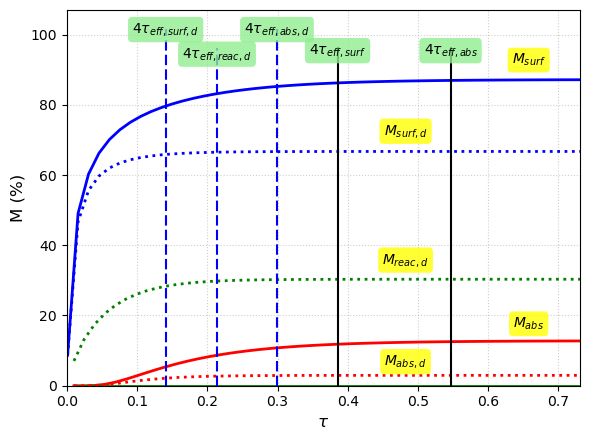

In [2]:
# Create colorful Figure 7 with text labels and vertical lines
fig, ax = plt.subplots(figsize=(6, 4.5))
# Plot all 6 curves
ax.plot(tau_evap, 100 * Mevap_values, color='blue', linestyle='-', linewidth=2)
ax.plot(tau_other, 100 * Mabs_values, color='red', linestyle='-', linewidth=2)  
ax.plot(tau_other, 100 * Mreac_values, color='green', linestyle='-', linewidth=2)
ax.plot(tau_evap, 100 * Mevap_r_values, color='blue', linestyle=':', linewidth=2)
ax.plot(tau_other, 100 * Mabs_r_values, color='red', linestyle=':', linewidth=2)
ax.plot(tau_other, 100 * Mreac_r_values, color='green', linestyle=':', linewidth=2)

# Calculate characteristic times using exact polynomial formulas from Mathematica
def teffevapr_formula(h, D1, Pe):
    """Exact polynomial formula for teff absorption decontamination"""
    numerator = h**2 * (175.967 + Pe * (192.353 + Pe * (77.7598 + 
                        Pe * (14.0033 + (1.06109 + 0.027128 * Pe) * Pe))))
    denominator = 3600 * D1 * (2445.62 + Pe * (3191.08 + Pe * (1591.58 + 
                               Pe * (368.627 + Pe * (37.0292 + 1.0 * Pe)))))
    return numerator / denominator

def teffabsr_formula(h, D1, Pe):
    """Exact polynomial formula for teff evaporation decontamination"""
    numerator = h**2 * (952.898 + Pe * (1343.76 + Pe * (765.779 + 
                        Pe * (223.721 + Pe * (34.7721 + (2.63178 + 
                                              0.0683604 * Pe) * Pe)))))
    denominator = 3600 * D1 * (9284.27 + Pe * (14204.5 + Pe * (8784.06 + 
                               Pe * (2778.15 + Pe * (464.369 + Pe * (37.2844 + 1.0 * Pe))))))
    return numerator / denominator

def teffreacr_formula(h, D1, Pe):
    """Exact polynomial formula for teff reaction decontamination"""
    numerator = h**2 * (1238.16 + Pe * (1588.5 + Pe * (812.268 + 
                        Pe * (210.563 + Pe * (29.0002 + (1.98458 + 
                                              0.0485842 * Pe) * Pe)))))
    denominator = 3600 * D1 * (15030.3 + Pe * (21722.7 + Pe * (12549.6 + 
                               Pe * (3656.61 + Pe * (553.974 + Pe * (39.8397 + 1.0 * Pe))))))
    return numerator / denominator

# Calculate characteristic times using the exact formulas
teff_abs_r = teffabsr_formula(h, D1, Pe)
teff_evap_r = teffevapr_formula(h, D1, Pe)  
teff_reac_r = teffreacr_formula(h, D1, Pe)

# For original versions, use the hardcoded values from your Mathematica code


def teffabs_formula(h, D1, Pe):
    numerator = h**2 * (3.34741e-14 + 
                       Pe * (-3.34741e-14 + 
                            Pe * (3.34741e-14 + 
                                 Pe * (2.51055e-14 + 
                                      Pe * (25.0252 + 
                                           Pe * (15.1903 + (3.01183 + 
                                                            0.116417 * Pe) * Pe))))))
    denominator = 3600 * D1 * Pe**2 * (1.0 + Pe) * (-1.6737e-14 + Pe**2 * (60.1005 + Pe * (22.9095 + 1.0 * Pe)))
    return numerator / denominator



def teffevap_formula(h, D1, Pe):
    numerator = h**2 * (-9.22623e-15 + 
                       Pe * (-9.22623e-15 + 
                            Pe * (9.22623e-15 + 
                                 Pe * (1.15328e-14 + 
                                      Pe * (8.82739 + (1.88284 + 
                                                       0.073 * Pe) * Pe)))))
    denominator = 3600 * D1 * Pe**4 * (1.0 + Pe) * (22.0526 + 1.0 * Pe)
    return numerator / denominator



teff_abs_orig = teffabs_formula(h, D1, Pe)
teff_evap_orig = teffevap_formula(h, D1, Pe)  

print(f"Characteristic times from exact formulas:")
print(f"  teff_abs_r = {teff_abs_r:.6f} hours")
print(f"  teff_evap_r = {teff_evap_r:.6f} hours")
print(f"  teff_reac_r = {teff_reac_r:.6f} hours")
print(f"  teff_abs_orig = {teff_abs_orig:.6f} hours")
print(f"  teff_evap_orig = {teff_evap_orig:.6f} hours")

# Convert to dimensionless for vertical lines
teff_abs_r_dim = teff_abs_r * 3600 / To
teff_evap_r_dim = teff_evap_r * 3600 / To  
teff_reac_r_dim = teff_reac_r * 3600 / To
teff_abs_orig_dim = teff_abs_orig * 3600 / To
teff_evap_orig_dim = teff_evap_orig * 3600 / To

# 5 Vertical lines using calculated values
ax.axvline(x=4*teff_evap_r_dim, color='blue', linestyle=(0, (5, 2)), linewidth=1.5, ymin=0, ymax=0.95)
ax.axvline(x=4*teff_abs_r_dim, color='blue', linestyle=(0, (5, 2)), linewidth=1.5, ymin=0, ymax=0.95) 
ax.axvline(x=4*teff_reac_r_dim, color='blue', linestyle=(0, (5, 2)), linewidth=1.5, ymin=0, ymax=0.90)
ax.axvline(x=4*teff_abs_orig_dim, color='black', linestyle='-', linewidth=1.5, ymin=0, ymax=0.90)
ax.axvline(x=4*teff_evap_orig_dim, color='black', linestyle='-', linewidth=1.5, ymin=0, ymax=0.90)

# Labels for characteristic times
ax.text(4*teff_abs_r_dim, 99, r'$4\tau_{eff, abs,d}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', edgecolor='none', alpha=0.8))
ax.text(4*teff_evap_r_dim, 99, r'$4\tau_{eff, surf,d}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', edgecolor='none', alpha=0.8))
ax.text(4*teff_reac_r_dim, 92, r'$4\tau_{eff, reac,d}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', edgecolor='none', alpha=0.8))
ax.text(4*teff_evap_orig_dim, 93, r'$4\tau_{eff, surf}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', edgecolor='none', alpha=0.8))
ax.text(4*teff_abs_orig_dim, 93, r'$4\tau_{eff, abs}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', edgecolor='none', alpha=0.8))


def Mabsinfr_formula(Da, Pe, beta):
    sqrt_Da = np.sqrt(Da)
    numerator = Pe * (-1 + np.cosh(sqrt_Da * beta)) + sqrt_Da * np.sinh(sqrt_Da * beta)
    denominator = Da * beta * np.cosh(sqrt_Da) + sqrt_Da * Pe * beta * np.sinh(sqrt_Da)
    return numerator / denominator
    

def Mevapinfr_formula(Da, Pe, beta):
    sqrt_Da = np.sqrt(Da)
    numerator = (np.exp(-sqrt_Da * (1 + beta)) * 
                 (np.exp(2 * sqrt_Da) - np.exp(sqrt_Da * beta)) * 
                 (-1 + np.exp(sqrt_Da * beta)) * Pe)
    denominator = (2 * sqrt_Da * beta * 
                   (sqrt_Da * np.cosh(sqrt_Da) + Pe * np.sinh(sqrt_Da)))
    return numerator / denominator


def Mreacinfr_formula(Da, Pe, beta):
    sqrt_Da = np.sqrt(Da)
    
    term1 = -np.exp(sqrt_Da * beta) * (-1 + np.exp(sqrt_Da)) * (-1 + np.exp(sqrt_Da * beta)) * (np.exp(sqrt_Da) + np.exp(sqrt_Da * beta)) * Pe
    term2 = Da * np.exp(2 * sqrt_Da * beta) * (1 + np.exp(2 * sqrt_Da)) * beta
    term3 = sqrt_Da * (np.exp(sqrt_Da * (1 + beta)) - np.exp(sqrt_Da * (1 + 3 * beta)) - 
                       np.exp(2 * sqrt_Da * beta) * Pe * beta + 
                       np.exp(2 * sqrt_Da * (1 + beta)) * Pe * beta)
    
    numerator = np.exp(-2 * sqrt_Da * beta) * (term1 + term2 + term3)
    denominator = sqrt_Da * (sqrt_Da - Pe + np.exp(2 * sqrt_Da) * (sqrt_Da + Pe)) * beta
    
    return numerator / denominator


# Test with your values
h = 13.4e-4
D1 = 7.29e-11
Pe = 11.17
Da = 10.0  # for the "r" version
fdep = 0.1


# Mass fraction labels using exact Mathematica infinite-time values
Mevapinf_r = Mevapinfr_formula(Da, Pe, fdep) # 0.667182
Mabsinf_r = Mabsinfr_formula(Da, Pe, fdep) #0.029541  
Mreacinf_r = Mreacinfr_formula(Da, Pe, fdep) # 0.303277

label_tau = 3.3 * 3600 / To
ax.text(label_tau, 100 * 1.05 * Mevapinf_r, r'$M_{surf,d}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', edgecolor='none', alpha=0.8))
ax.text(label_tau, 100 * 1.5 * Mabsinf_r, r'$M_{abs,d}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', edgecolor='none', alpha=0.8))
ax.text(label_tau, 100 * 1.1 * Mreacinf_r, r'$M_{reac,d}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', edgecolor='none', alpha=0.8))

label_tau_orig = 4.5 * 3600 / To
ax.text(label_tau_orig, 100 * 1.13 * 0.8, r'$M_{surf}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', edgecolor='none', alpha=0.8))
ax.text(label_tau_orig, 100 * 1.7 * 0.09, r'$M_{abs}$', fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', edgecolor='none', alpha=0.8))

ax.set_xlabel(r'$\tau$', fontsize=12)
ax.set_ylabel(r'M (%)', fontsize=12)
ax.set_xlim(0, tau_max)
ax.set_ylim(0, 107)
ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()


# Show the figure LAST
plt.show()